In [1]:
import pandas as pd
import torch
from einops import rearrange
from util import Keypoint, draw_bodypose
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from util import create_image_grid_with_borders, draw_bodypose, translate_to_keyppoints

In [9]:
VERSION = 'v2'
random.seed(42)

In [3]:
NECK = 1
def scale_pose(poses, scale):
    poses = poses.clone()
    meanx = poses[:, :, 0].mean(dim=1)
    meany = poses[:, :, 1].mean(dim=1)
    poses[:, :, 0] -= meanx.unsqueeze(1)
    poses[:, :, 1] -= meany.unsqueeze(1)
    poses[:, :, 0] *= scale[0]
    poses[:, :, 1] *= scale[1]
    poses[:, :, 0] += meanx.unsqueeze(1)
    poses[:, :, 1] += meany.unsqueeze(1)
    return poses

def calculate_relative_points(poses):
    res = poses.clone()
    res -= poses[:, NECK:NECK+1, :] # subtract neck
    return res

In [4]:
df = pd.read_csv('data/poses.csv')
df = df[~(df['class'].isin(['squat', 'wave']))] # remove squats and waves
df = df.drop('class', axis=1) # remove class column
df = df[~(df == 0).any(axis=1)] # remove rows with any zeros - undefined ponints
poses = torch.tensor(df.values, dtype=torch.float32) # convert to tensor
poses = rearrange(poses, 'n (ps p) -> n ps p', p=2) # rearrange to (n, 18, 2)
poses = scale_pose(poses, (1.6, 1.0)) # fix x-axis points
poses = calculate_relative_points(poses) # change to relative to NECK

In [5]:
# augument the dataset with scaling
get_scale = lambda : random.uniform(1.0, 3.8)
REPETITIONS = 10
res = []
for n in range(REPETITIONS):
    poses_scaled = poses.clone()
    scale = get_scale()
    poses_scaled *= scale
    res.append(poses_scaled)
poses_scaled = torch.cat(res, dim=0)

In [6]:
# augument the dataset with missing points
missing_conf = [
    [], # no missing
    [10, 13],
    [9, 10, 12, 13],
    [8, 9, 10, 11, 12, 13],
    [4,7,8,9,10,11,12,13],
    [4,7,9,10,12,13],
    [3,4,6,7,8,9,10,11,12,13],
    [7,9,10,12,13],
    [4,9,10,12,13],
    [6,7],
    [3,4],
    [16],
    [17],
    [14,16],
    [15,17],
    [14,15,16,17]
]
res = []
for conf in missing_conf:
    poses_missing = poses_scaled.clone()
    poses_missing[:, conf, :] = -10.0
    res.append(poses_missing)
poses_missing = torch.cat(res, dim=0)

In [7]:
# augument dataset based on image ratio
nposes = poses_missing.shape[0]
ratios = [1344/768, 1.0, 768/1344]
ratios_df = torch.cat([
    torch.ones(nposes, 1) * ratios[0],
    torch.ones(nposes, 1) * ratios[1],
    torch.ones(nposes, 1) * ratios[2],
], dim=0).squeeze()
res = []
for ratio in ratios:
    poses_ratio = poses_missing.clone()
    poses_ratio[:, :, 0] *= ratio
    res.append(poses_ratio)
poses = torch.cat(res, dim=0)

In [14]:
# check if ratios and points are of the same length
assert poses.shape[0] == ratios_df.shape[0]

In [16]:
data_dir = f'data/{VERSION}'
os.makedirs(data_dir, exist_ok=True)
torch.save(poses, os.path.join(data_dir, 'poses.pt'))
torch.save(ratios_df, os.path.join(data_dir, 'ratios.pt'))

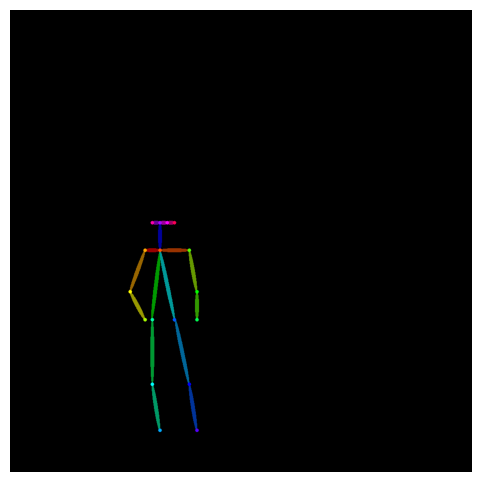

In [16]:
h, w = 1024, 1024
images = [Image.fromarray(draw_bodypose(np.zeros((h, w, 3), dtype=np.uint8), translate_to_keyppoints(poses[i].numpy()))) 
          for i in random.sample(range(0, poses.shape[0] + 1), 6)]
grid_img = create_image_grid_with_borders(images, 1, 1)
fig = plt.figure(figsize=(6, 6))
plt.imshow(grid_img)
plt.axis('off')
plt.show();